# Contour Plot of Prediction of Cavity Problem

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import sys
import os
import torch
import numpy as np
import torch.nn as nn

import h5py
import pandas as pd
from matplotlib import pyplot as plt

Import local packages

In [23]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils.logger import Logging
from src.utils.plot_prediction import plot_contour

Set various constant variables: model path, name, etc.

In [24]:
TEST_DATA_PKL = "../../data/cavity.mat"
TEST_CHECKPOINT_PATH = os.path.join(PROJECT_ROOT, "result/cavity")


SOLVER_TO_MODULE = {
    "KAN_BSpline": "src.nn.bspline",
    "MLP2": "src.nn.tanh",
}

TANH_NORM_DIST = "../../model/a2/cavity_tanh_normal_a2.pth"
BSPLINE_DIST = "../../model/a2/cavity_bspline_a2.pth"

# Load the state from the saved model

MODULE_LIST = {
    "tanh": TANH_NORM_DIST,
    "bspline": BSPLINE_DIST,
}

MODULE_DICT = {
    "tanh": [],
    "bspline": [],
}

Create logger path

In [25]:
logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

## Load Testing Data

In [26]:
data = h5py.File(TEST_DATA_PKL, "r")  # load dataset from matlab

domain = pd.DataFrame(data["cavity_internal"]).T.to_numpy()

#  t = tf.reshape(tstep,N_data)[:,0].T
time_ = domain[:, 0:1]
xfa = domain[:, 1:2]
yfa = domain[:, 2:3]
ufa = domain[:, 3:4]
vfa = domain[:, 4:5]
pfa = domain[:, 5:6]


test_torch_data = torch.tensor(
    np.concatenate([time_, xfa, yfa], axis=1), dtype=torch.float32
).to("cpu")

## Load and Test Model




In [27]:
for key, model in MODULE_LIST.items():
    state = torch.load(model)
    config = state.get("config", {})
    solver = config.get("solver")

    # Log model summary and configuration
    logger.print("_summary of the model _")
    logger.print("model path:", model)
    logger.print("model configuration:")
    for k, v in config.items():
        logger.print(f"{k} : {v}")

    # Dynamically import the correct module and class
    if solver in SOLVER_TO_MODULE:
        module = __import__(SOLVER_TO_MODULE[solver], fromlist=["PINNKAN"])
        PINNKAN = getattr(module, "PINNKAN")

        # Initialize fluid and solid models
        model = PINNKAN(config.get("network"), config.get("activation")).to("cpu")

    model.load_state_dict(state["model_state_dict"])
    model.eval()

    with torch.no_grad():
        predictions = model.forward(test_torch_data)
    if predictions.is_cuda:
        predictions = predictions.cpu()
    u_pred = predictions[:, 0:1].numpy()
    v_pred = predictions[:, 1:2].numpy()
    p_pred = predictions[:, 2:3].numpy()

    # Relative L2 error
    error_u = np.linalg.norm(u_pred - ufa, 2) / np.linalg.norm(ufa, 2) * 100
    error_v = np.linalg.norm(v_pred - vfa, 2) / np.linalg.norm(vfa, 2) * 100
    error_p = np.linalg.norm(p_pred - pfa, 2) / np.linalg.norm(pfa, 2) * 100
    logger.print("Relative L2 error_u: {:.2e}".format(error_u.item()))
    logger.print("Relative L2 error_v: {:.2e}".format(error_v.item()))
    logger.print("Relative L2 error_p: {:.2e}".format(error_p.item()))

    MODULE_DICT[key] = [u_pred, v_pred, p_pred]
    logger.print("***********************************************************")

INFO:src.utils.logger:_summary of the model _
INFO:src.utils.logger:model path:
INFO:src.utils.logger:../../model/a2/cavity_tanh_normal_a2.pth
INFO:src.utils.logger:model configuration:
INFO:src.utils.logger:batch_size : 128
INFO:src.utils.logger:network : [3, 300, 300, 300, 3]
INFO:src.utils.logger:weights : [2.0, 2.0, 2.0, 2.0, 2.0, 0.1]
INFO:src.utils.logger:solver : MLP2
INFO:src.utils.logger:total_epochs : 60000
INFO:src.utils.logger:print_every : 10000
INFO:src.utils.logger:save_every : 10000
INFO:src.utils.logger:activation : tanh2
INFO:src.utils.logger:loss_list : ['lleft', 'lright', 'lbottom', 'lup', 'linitial', 'lphy']
INFO:src.utils.logger:log_path : /home/vlq26735/saiful/afrah/code/PINN4Cavity/checkpoints/cavity


INFO:src.utils.logger:Relative L2 error_u: 1.08e+01
INFO:src.utils.logger:Relative L2 error_v: 2.21e+01
INFO:src.utils.logger:Relative L2 error_p: 2.45e+01
INFO:src.utils.logger:***********************************************************
INFO:src.utils.logger:_summary of the model _
INFO:src.utils.logger:model path:
INFO:src.utils.logger:../../model/a2/cavity_bspline_a2.pth
INFO:src.utils.logger:model configuration:
INFO:src.utils.logger:batch_size : 128
INFO:src.utils.logger:network : [3, 100, 100, 100, 3]
INFO:src.utils.logger:weights : [2.0, 2.0, 2.0, 2.0, 2.0, 0.1]
INFO:src.utils.logger:solver : KAN_BSpline
INFO:src.utils.logger:total_epochs : 60000
INFO:src.utils.logger:print_every : 10000
INFO:src.utils.logger:save_every : 10000
INFO:src.utils.logger:activation : KAN_BSpline
INFO:src.utils.logger:loss_list : ['lleft', 'lright', 'lbottom', 'lup', 'linitial', 'lphy']
INFO:src.utils.logger:log_path : /home/vlq26735/saiful/afrah/code/PINN4Cavity/checkpoints/cavity
INFO:src.utils.logg

## Plot Test Result

Reshape ...

In [28]:
tstep = 101
xstep = 100
ystep = 100

txy = [xfa, yfa, time_]
steps = [tstep, xstep, ystep]

#  t = tf.reshape(tstep,N_data)[:,0].T
tf = time_.reshape(tstep, xstep, ystep)
xf = xfa.reshape(tstep, xstep, ystep)
yf = yfa.reshape(tstep, xstep, ystep)


u_pred_tanh = MODULE_DICT["tanh"][0]
v_pred_tanh = MODULE_DICT["tanh"][1]
p_pred_tanh = MODULE_DICT["tanh"][2]

u_pred_bspline = MODULE_DICT["bspline"][0]
v_pred_bspline = MODULE_DICT["bspline"][1]
p_pred_bspline = MODULE_DICT["bspline"][2]


ufa = ufa.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
vfa = vfa.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
pfa = pfa.reshape(tstep, xstep, ystep)  # [1,:].reshape(100,100)[0,:]

u_pred_tanh = u_pred_tanh.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
v_pred_tanh = v_pred_tanh.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
p_pred_tanh = p_pred_tanh.reshape(tstep, xstep, ystep)  # [1,:].reshape(100,100)[0,:]

u_pred_bspline = u_pred_bspline.reshape(tstep, xstep, ystep)
v_pred_bspline = v_pred_bspline.reshape(tstep, xstep, ystep)
p_pred_bspline = p_pred_bspline.reshape(tstep, xstep, ystep)

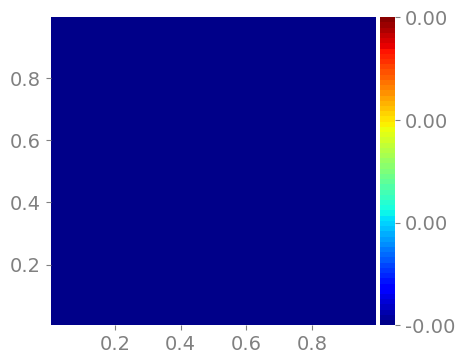

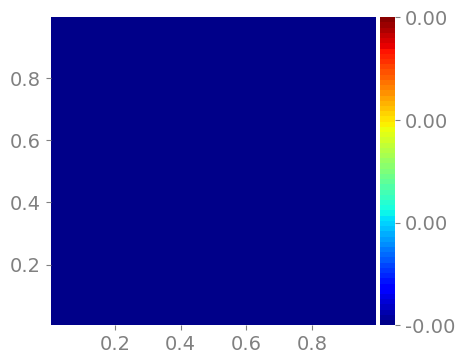

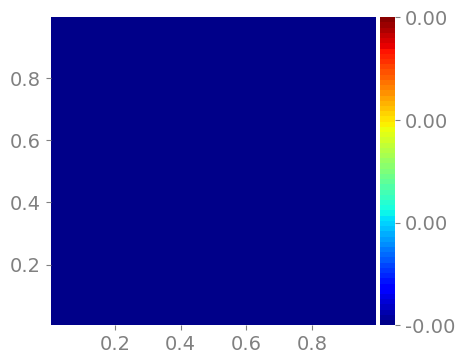

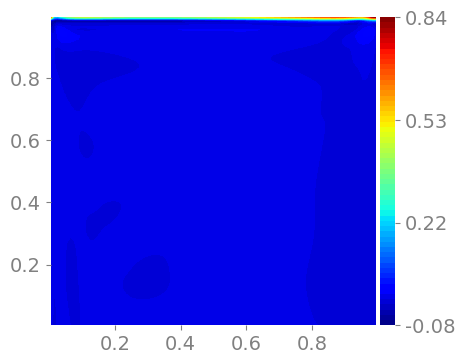

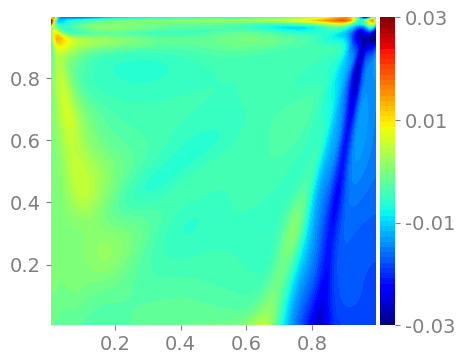

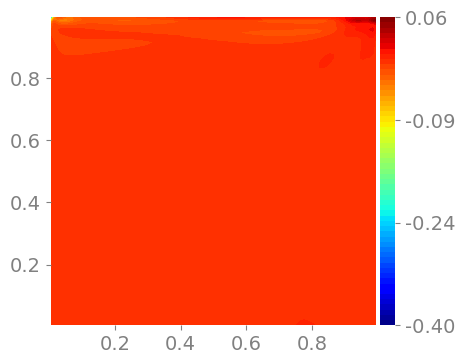

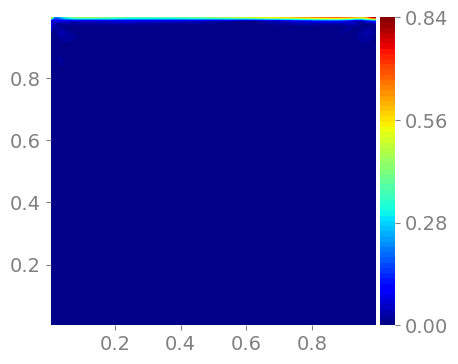

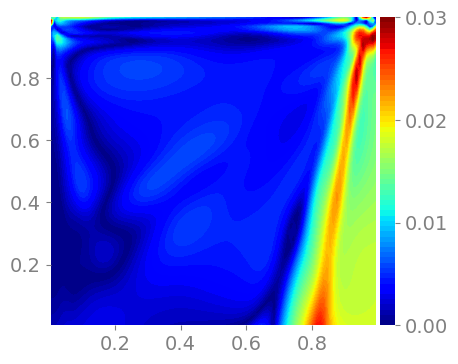

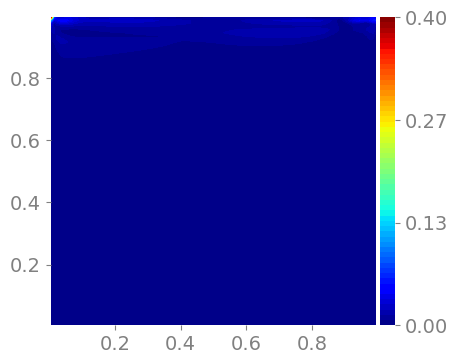

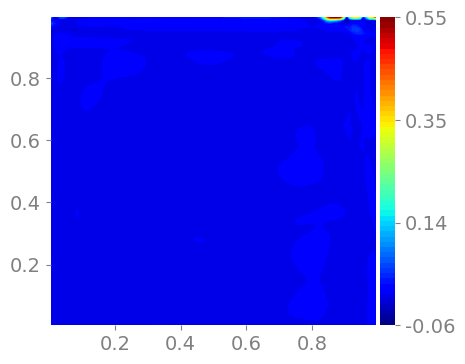

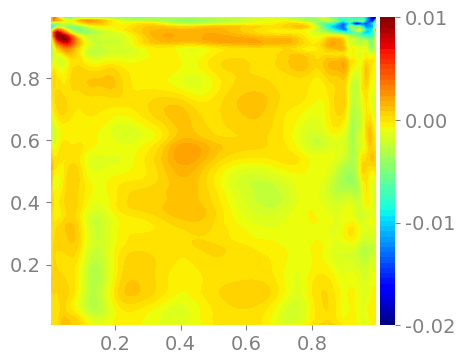

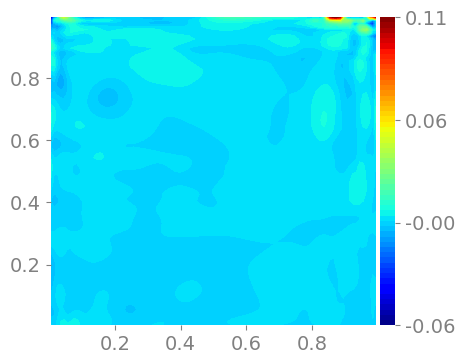

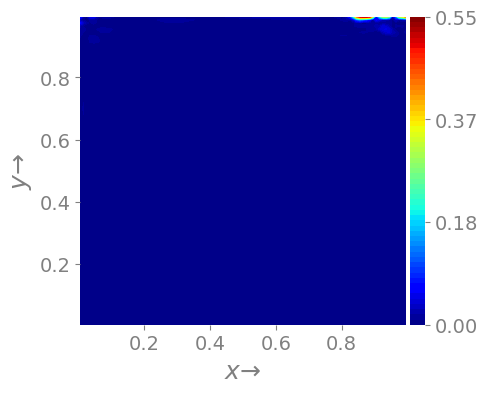

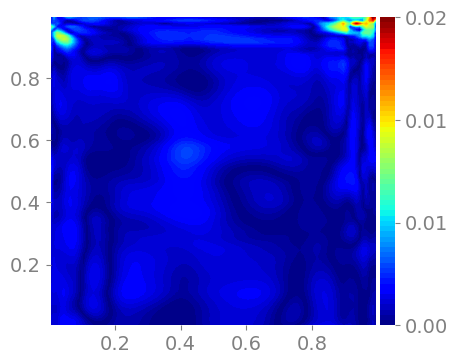

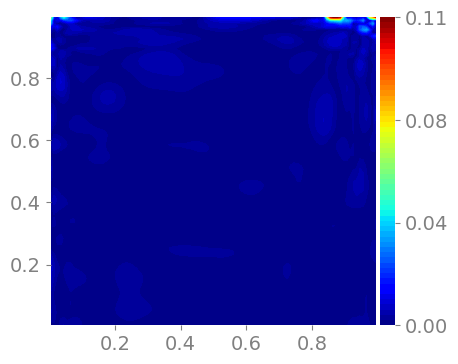

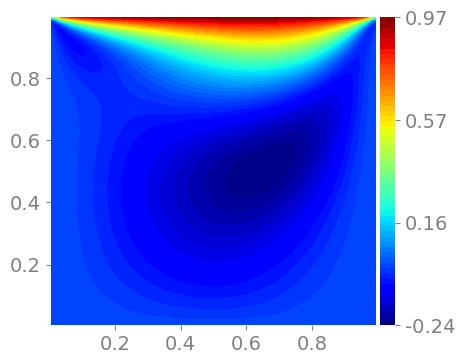

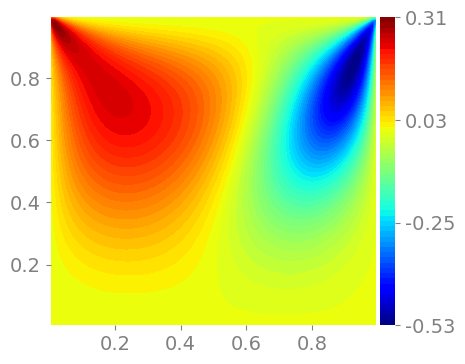

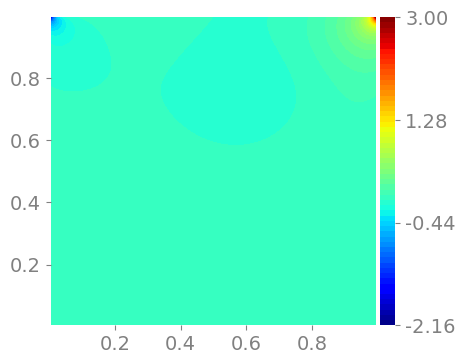

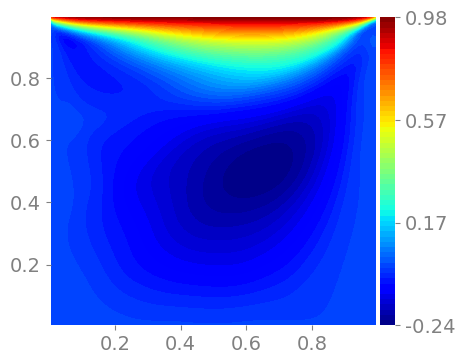

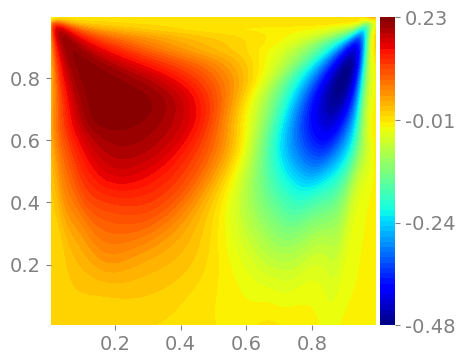

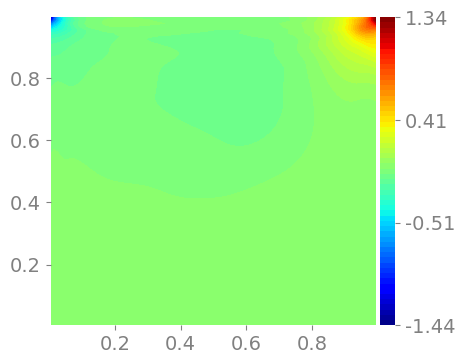

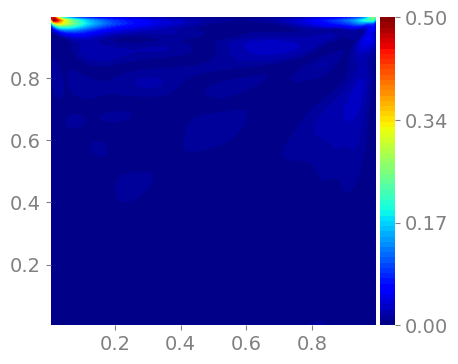

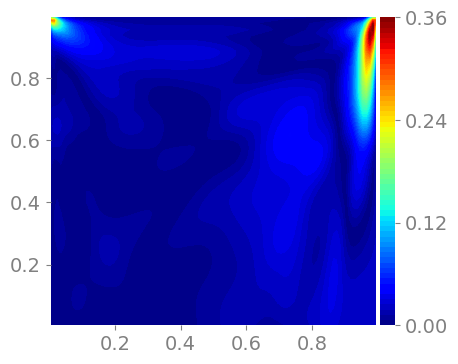

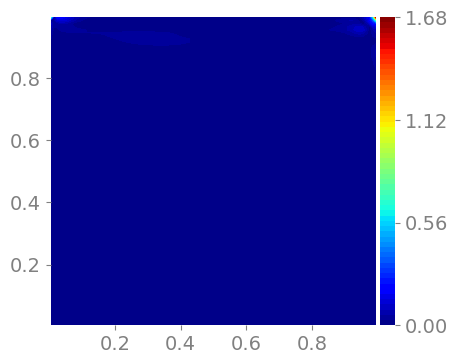

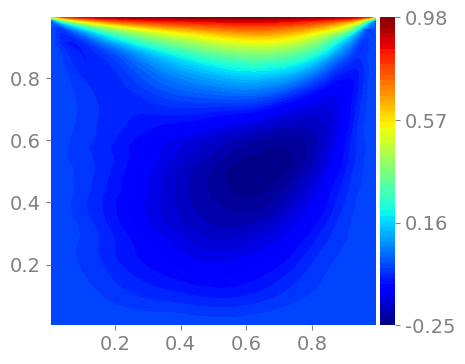

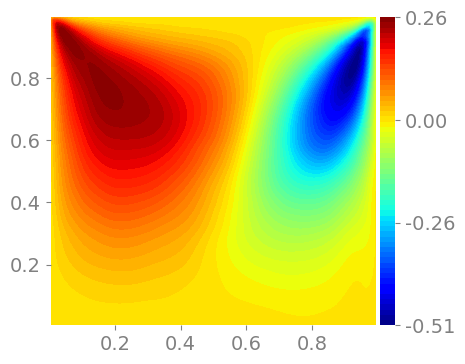

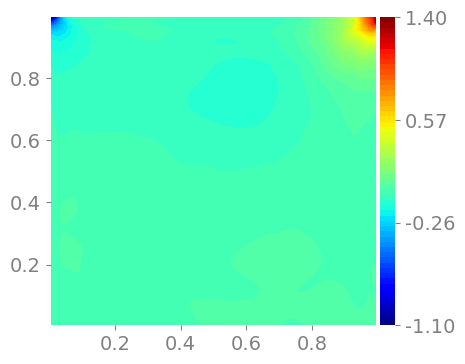

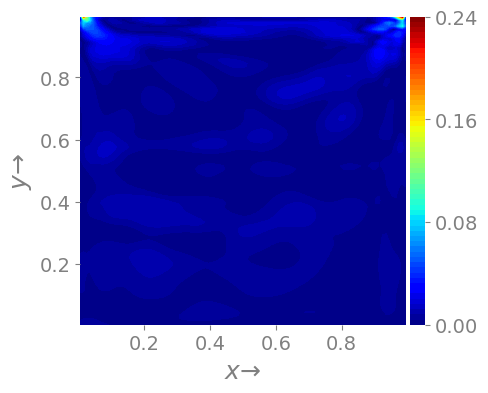

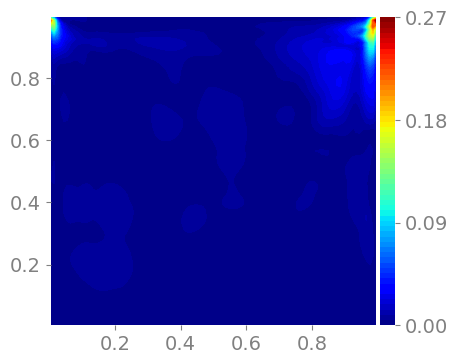

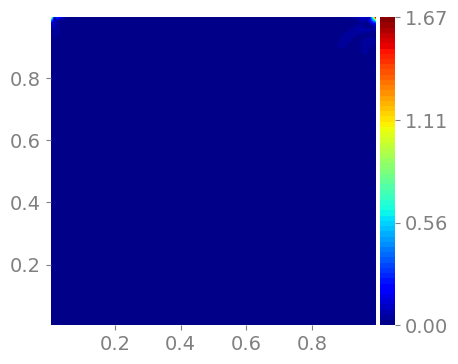

In [32]:
exact_u = ufa
exact_v = vfa
exact_p = pfa

tanh_u = u_pred_tanh
tanh_v = v_pred_tanh
tanh_p = p_pred_tanh

tanh_error_u = np.abs(u_pred_tanh - ufa)
tanh_error_v = np.abs(v_pred_tanh - vfa)
tanh_error_p = np.abs(p_pred_tanh - pfa)

bspline_u = u_pred_bspline
bspline_v = v_pred_bspline
bspline_p = p_pred_bspline

bspline_error_u = np.abs(u_pred_bspline - ufa)
bspline_error_v = np.abs(v_pred_bspline - vfa)
bspline_error_p = np.abs(p_pred_bspline - pfa)

data = [
    exact_u,
    exact_v,
    exact_p,
    tanh_u,
    tanh_v,
    tanh_p,
    tanh_error_u,
    tanh_error_v,
    tanh_error_p,
    bspline_u,
    bspline_v,
    bspline_p,
    bspline_error_u,
    bspline_error_v,
    bspline_error_p,
]

titles = [
    "exact_u",
    "exact_v",
    "exact_p",
    "tanh_u",
    "tanh_v",
    "tanh_p",
    "tanh_error_u",
    "tanh_error_v",
    "tanh_error_p",
    "bspline_u",
    "bspline_v",
    "bspline_p",
    "bspline_error_u",
    "bspline_error_v",
    "bspline_error_p",
]

plot_xy = False

time_steps = [0, 99]
xy_labels = [r"$x→$", r"$y→$"]

x = xf[0, :, :][..., None]
y = yf[0, :, :][..., None]

X = np.concatenate([x, y], axis=-1)
for time_step in time_steps:
    for index, (title, z) in enumerate(zip(titles, data)):
        file_name = os.path.join(model_dirname, f"{index}_{title}_time{time_step}.png")
        plot_xy = index == 12
        fig = plot_contour(X, z[time_step, :, :], file_name, plot_xy, xy_labels)